<a href="https://colab.research.google.com/github/vkbyba/goit-ds-hw-10/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%94_%D0%B7%D0%B0%D0%B2%D0%B4%D0%B0%D0%BD%D0%BD%D1%8F_Module_7%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
def loadMovieList():

    with open('movie_ids.txt', encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

## Рекомендаційні системи

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

In the next parts of this exercise, you will implement the function `cofiCostFunc` that computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, you will use `scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The next cell will load the dataset `movies.mat`, providing the variables `Y` and `R`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

In [ ]:
names = loadMovieList()

Average rating for movie 1601 ( Office Killer (1997) ): 0.000000 / 5


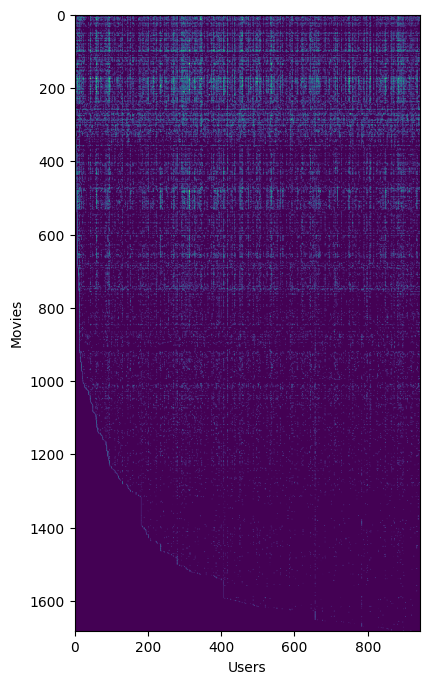

In [ ]:


# Load data
data = loadmat('movies.mat')
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1
# if and only if user j gave a rating to movie i

# Assuming 'names' is a list of movie names loaded from somewhere
# names = loadMovieList()  # This should be defined elsewhere in your code

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1601 (', names[1600], '): %f / 5' %
      np.mean(Y[1600, R[1600, :]]))

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)
plt.show()

Throughout this part of the exercise, you will also be working with the matrices, `X` and `W`:

$$ \text{X} =
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{W} =
\begin{bmatrix}
- \left(w^{(1)}\right)^T - \\
- \left(w^{(2)}\right)^T - \\
\vdots \\
- \left(w^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of `W` corresponds to one parameter vector $w^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $w^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $w^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `W` is a $n_u \times 100$ matrix.

<a id="section3"></a>
### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $w^{(1)} , \dots, w^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( w^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `W`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. You had previously used the same vector unrolling method in the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

You should now modify the function `cofiCostFunc` to return this cost in the variable `J`. Note that you should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

<div class="alert alert-block alert-warning">
**Implementation Note**: We strongly encourage you to use a vectorized implementation to compute $J$, since it will later by called many times by `scipy`'s optimization package. As usual, it might be easiest to first write a non-vectorized implementation (to make sure you have the right answer), and the modify it to become a vectorized implementation (checking that the vectorization steps do not change your algorithm’s output). To come up with a vectorized implementation, the following tip might be helpful: You can use the $R$ matrix to set selected entries to 0. For example, `R * M` will do an element-wise multiplication between `M`
and `R`; since `R` only has elements with values either 0 or 1, this has the effect of setting the elements of M to 0 only when the corresponding value in R is 0. Hence, `np.sum( R * M)` is the sum of all the elements of `M` for which the corresponding element in `R` equals 1.
</div>

<a id="cofiCostFunc"></a>

In [ ]:

def cofiCostFunc(params, Y, R, num_users, num_movies, num_features):

    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    prediction = X @ W.T
    error = prediction - Y
    error_factor = error * R

    J = 0.5 * np.sum(np.square(error_factor))

    X_grad = error_factor @ W
    W_grad = error_factor.T @ X

    grad = np.concatenate([X_grad.ravel(), W_grad.ravel()])
    return J, grad

<a id="section4"></a>
#### 2.2.2 Collaborative filtering gradient

Now you should implement the gradient (without regularization). Specifically, you should complete the code in `cofiCostFunc` to return the variables `X_grad` and `W_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `W_grad` is a matrix of the same size as
`W`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) w_k^{(j)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the next cell run a gradient check
(available in `utils.checkCostFunction`) to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

<div class="alert alert-block alert-warning">
**Implementation Note:** You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation. To get started, you can implement the gradient with a for-loop over movies
(for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{w_k^{(j)}}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorize the inner for-loops), so that you are left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x_k^{(i)}}$ for each movie, and one for looping over users to compute $\frac{\partial J}{\partial w_k^{(j)}}$ for each user).
</div>

<div class="alert alert-block alert-warning">
**Implementation Tip:** To perform the vectorization, you might find this helpful: You should come up with a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. Let us define the derivatives for the feature vector of the $i^{th}$ movie as:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T =
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) w^{(j)}
$$

To vectorize the above expression, you can start by indexing into `W` and `Y` to select only the elements of interests (that is, those with `r[i, j] = 1`). Intuitively, when you consider the features for the $i^{th}$ movie, you only need to be concerned about the users who had given ratings to the movie, and this allows you to remove all the other users from `W` and `Y`. <br/><br/>


Concretely, you can set `idx = np.where(R[i, :] == 1)[0]` to be a list of all the users that have rated movie $i$. This will allow you to create the temporary matrices `W_temp = W[idx, :]` and `Y_temp = Y[i, idx]` that index into `W` and `Y` to give you only the set of users which have rated the $i^{th}$ movie. This will allow you to write the derivatives as: <br>

`X_grad[i, :] = np.dot(np.dot(X[i, :], W_temp.T) - Y_temp, W_temp)`

<br><br>
Note that the vectorized computation above returns a row-vector instead. After you have vectorized the computations of the derivatives with respect to $x^{(i)}$, you should use a similar method to vectorize the derivatives with respect to $w^{(j)}$ as well.
</div>

In [ ]:

def cofiCostFunc(params, Y, R, num_users, num_movies, num_features):

    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    prediction = X @ W.T
    error = prediction - Y
    error_factor = error * R

    J = 0.5 * np.sum(np.square(error_factor))

    X_grad = error_factor @ W
    W_grad = error_factor.T @ X

    grad = np.concatenate([X_grad.ravel(), W_grad.ravel()])
    return J, grad

<a id="section5"></a>
#### 2.2.3 Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( w_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

You should now add regularization to your original computations of the cost function, $J$. After you are done, the next cell will run your regularized cost function, and you should expect to see a cost of about 31.34.

In [ ]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):

    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    prediction = X @ W.T
    error = prediction - Y
    error_factor = error * R

    J = 0.5 * np.sum(np.square(error_factor))

    J += (lambda_ / 2) * (np.sum(np.square(W)) + np.sum(np.square(X)))

    X_grad = error_factor @ W + lambda_ * X
    W_grad = error_factor.T @ X + lambda_ * W

    grad = np.concatenate([X_grad.ravel(), W_grad.ravel()])
    return J, grad

<a id="section6"></a>
#### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in `cofiCostFunc` to return the regularized gradient
by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) w_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda w_k^{(j)} $$

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad[i,:]` variable described earlier, and add $\lambda w^{(j)}$ to the `W_grad[j, :]` variable described earlier.

In [ ]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):

    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    prediction = X @ W.T
    error = prediction - Y
    error_factor = error * R

    J = 0.5 * np.sum(np.square(error_factor))


    J += (lambda_ / 2) * (np.sum(np.square(W)) + np.sum(np.square(X)))

    X_grad = error_factor @ W + lambda_ * X
    W_grad = error_factor.T @ X + lambda_ * W

    grad = np.concatenate([X_grad.ravel(), W_grad.ravel()])
    return J, grad

### 2.3 Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`.

In [ ]:
movieList = loadMovieList()

In [ ]:
movies_id_list = [0, 97, 6, 11, 53, 63, 65, 68, 182, 225, 354]

for movie in movies_id_list:
  print(movieList[movie])



Toy Story (1995)
Silence of the Lambs, The (1991)
Twelve Monkeys (1995)
Usual Suspects, The (1995)
Outbreak (1995)
Shawshank Redemption, The (1994)
While You Were Sleeping (1995)
Forrest Gump (1994)
Alien (1979)
Die Hard 2 (1990)
Sphere (1998)


#### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the script
will proceed to train the collaborative filtering model. This will learn the
parameters `X` and `W`. To predict the rating of movie $i$ for user $j$, you need to compute $(w^{(j)})^T x^{(i)}$ . The next part of the script computes the ratings for
all the movies and users and displays the movies that it recommends (Figure
4), according to ratings that were entered earlier in the script. Note that
you might obtain a different set of the predictions due to different random
initializations.

Top recommendations for you:
Predicting rating 3.2 for movie Titanic (1997)
Predicting rating 3.1 for movie Good Will Hunting (1997)
Predicting rating 3.0 for movie Boot, Das (1981)
Predicting rating 3.0 for movie Schindler's List (1993)
Predicting rating 3.0 for movie Raiders of the Lost Ark (1981)
Predicting rating 2.9 for movie Star Wars (1977)
Predicting rating 2.9 for movie L.A. Confidential (1997)
Predicting rating 2.9 for movie As Good As It Gets (1997)
Predicting rating 2.9 for movie Braveheart (1995)
Predicting rating 2.9 for movie One Flew Over the Cuckoo's Nest (1975)


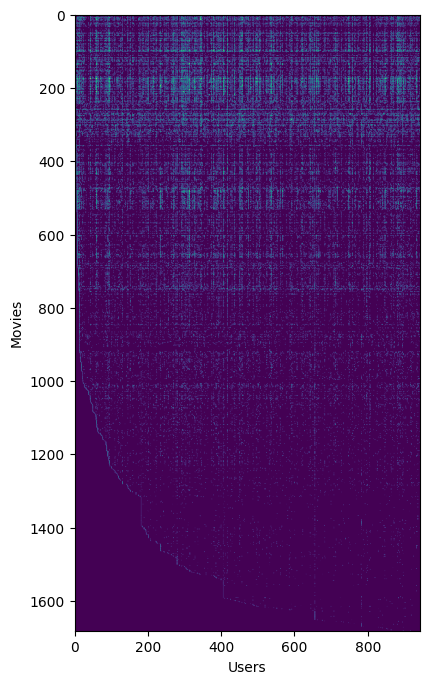

In [ ]:
def loadMovieList():
    with open('movie_ids.txt', encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

data = loadmat('movies.mat')
Y, R = data['Y'], data['R']

# Your movie ratings
my_ratings = np.zeros((1682, 1))


my_ratings[0] = 5   # Toy Story (1995)
my_ratings[97] = 5  # GoldenEye (1995)
my_ratings[6] = 5   # Four Rooms (1995)
my_ratings[11] = 3  # Get Shorty (1995)
my_ratings[53] = 4  # Copycat (1995)
my_ratings[63] = 3  # Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
my_ratings[65] = 3  # Twelve Monkeys (1995)
my_ratings[68] = 2  # Babe (1995)
my_ratings[182] = 1 # Dead Man Walking (1995)
my_ratings[225] = 2 # Richard III (1995)
my_ratings[354] = 4 # Usual Suspects, The (1995)


Y = np.hstack([Y, my_ratings])
R = np.hstack([R, my_ratings != 0])

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 100
lambda_ = 10

X = np.random.randn(num_movies, num_features)
W = np.random.randn(num_users, num_features)
initial_params = np.concatenate([X.ravel(), W.ravel()])

def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    prediction = X @ W.T
    error = prediction - Y
    error_factor = error * R

    J = 0.5 * np.sum(np.square(error_factor))
    J += (lambda_ / 2) * (np.sum(np.square(W)) + np.sum(np.square(X)))

    X_grad = error_factor @ W + lambda_ * X
    W_grad = error_factor.T @ X + lambda_ * W

    grad = np.concatenate([X_grad.ravel(), W_grad.ravel()])
    return J, grad

result = minimize(fun=cofiCostFunc, x0=initial_params, args=(Y, R, num_users, num_movies, num_features, lambda_),
                  method='CG', jac=True, options={'maxiter': 100})

X = result.x[:num_movies * num_features].reshape(num_movies, num_features)
W = result.x[num_movies * num_features:].reshape(num_users, num_features)

my_predictions = X @ W.T[:, -1] + my_ratings.flatten()

sorted_indices = np.argsort(my_predictions)[::-1]

movie_list = loadMovieList()

print("Top recommendations for you:")
recommended_count = 0
for i in range(len(sorted_indices)):
    j = sorted_indices[i]
    if my_ratings[j] == 0:  # Skip movies you have already rated
        print(f"Predicting rating {my_predictions[j]:.1f} for movie {movie_list[j]}")
        recommended_count += 1
        if recommended_count == 10:
            break

# Visualize the ratings matrix
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)
plt.show()